## UNSUPERVISED LEARNING MINI PROJECT

### CONTEXT

> E-commerce has become a new channel to support businesses development. Through e-commerce, businesses can get access and establish a wider market presence by providing cheaper and more efficient distribution channels for their products or services. E-commerce has also changed the way people shop and consume products and services. Many people are turning to their computers or smart devices to order goods, which can easily be delivered to their homes.

### CONTENT
> This is a sales transaction data set of UK-based e-commerce (online retail) for one year. This London-based shop has been selling gifts and homewares for adults and children through the website since 2007. Their customers come from all over the world and usually make direct purchases for themselves. There are also small businesses that buy in bulk and sell to other customers through retail outlet channels.

> The data set contains 500K rows and 8 columns. The following is the description of each column.

> - **TransactionNo (categorical)**: a six-digit unique number that defines each transaction. The letter “C” in the code indicates a cancellation.
> - **Date (numeric)**: the date when each transaction was generated.
> - **ProductNo (categorical)**: a five or six-digit unique character used to identify a specific product.
> - **Product (categorical)**: product/item name.
> - **Price (numeric)**: the price of each product per unit in pound sterling (£).
> - **Quantity (numeric)**: the quantity of each product per transaction. Negative values related to cancelled transactions.
> - **CustomerNo (categorical)**: a five-digit unique number that defines each customer.
> - **Country (categorical)**: name of the country where the customer resides.

### GOAL

> Gather useful intrinsic information by combining RFM model and some unsupervised learning model. 

> For each segments, analyze the data, and try to answer the following questions:

> - How was the sales trend over the months?
> - What are the most frequent purchased products?
> - How many products does the customer purchase in each transaction?
> - How does each cluster/group contribute to the company's revenue?
> - What are the interval date between transactions?
> - Based on your findings, what strategy could you recommend to the business to gain more profit?
> - ***add more if necessary***

> Also, there is a small percentage of order cancellation in the data set. Most of these cancellations were due to out-of-stock conditions on some products. Under this situation, customers tend to cancel an order as they want all products delivered all at once. 

> Therefore, try to build a supervised learning model to solve this problem.

> Source from UCI Machine Learning Repository: [link to dataset](https://archive.ics.uci.edu/ml/datasets/online+retail)

## OVERVIEW

In [1]:
# import all necessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split

# Library untuk clustering
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import cdist

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


> Here we will inspect the data for quality checking.

In [3]:
# load data
df = pd.read_excel('drive/MyDrive/data/Online Retail.xlsx')

In [4]:
# check head
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [5]:
# check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


> We can see that there are 2 features with missing values (null).

In [6]:
# check null
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

## PREPROCESSING

> Since many of the missing values is on the important features (CustomerID), and it's considered as an identifier that will plays an important role to the RFM models, therefore we cannot do anything to this other than dropping the values on this features.

In [7]:
# dropna
df = df.dropna()

In [8]:
# check info after dropping
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.9+ MB


> Since the missing values has been handled, next we will try to create a new features (TotalCost) that will play an important role on RFM for monetary value later.

> *TotalCost = Quantity x UnitPrice*.

In [9]:
# create TotalCost
df["TotalCost"] = df["Quantity"]*df["UnitPrice"]

In [10]:
# check new features
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


> Then we will adjust the InvoiceDate format. We will create a new feature for it, so that it will fit the RFM model.

In [11]:
# create new feature and change its type
df["TransactionDate"] = pd.to_datetime(df["InvoiceDate"]).dt.date
df["TransactionDate"] = pd.to_datetime(df["TransactionDate"])

In [12]:
# check new features
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost,TransactionDate
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01


> We will also prepare the 'target' feature for supervised prediction later.

In [13]:
# prepare target feature, 1 : cancelled order, 0 : completed order
cancel = []
for i in df["InvoiceNo"]:
    if str(i).startswith("C"):
        cancel.append(1)
    else:
        cancel.append(0)

In [14]:
# apply target
df["cancelled"] = cancel

In [15]:
# check info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   InvoiceNo        406829 non-null  object        
 1   StockCode        406829 non-null  object        
 2   Description      406829 non-null  object        
 3   Quantity         406829 non-null  int64         
 4   InvoiceDate      406829 non-null  datetime64[ns]
 5   UnitPrice        406829 non-null  float64       
 6   CustomerID       406829 non-null  float64       
 7   Country          406829 non-null  object        
 8   TotalCost        406829 non-null  float64       
 9   TransactionDate  406829 non-null  datetime64[ns]
 10  cancelled        406829 non-null  int64         
dtypes: datetime64[ns](2), float64(3), int64(2), object(4)
memory usage: 37.2+ MB


> Now that we've finished the preprocess, we will copy the data and then start to build the rfm model.

In [16]:
# create copy for rfm modeling
df1 = df.copy()

## RFM MODEL BUILDING

> `explanation here`

In [17]:
now = df1['TransactionDate'].max()

In [18]:
recency = df1.groupby(by='CustomerID', as_index=False)['TransactionDate'].max()
recency.columns = ['CustomerID', 'last_trans_date']

recency['last_trans_date'] = pd.to_datetime(recency['last_trans_date'])
recency['recency'] = recency['last_trans_date'].apply(lambda x: (now-x).days)

In [19]:
recency.head()

,CustomerID,last_trans_date,recency
0,12346.0,2011-01-18,325
1,12347.0,2011-12-07,2
2,12348.0,2011-09-25,75
3,12349.0,2011-11-21,18
4,12350.0,2011-02-02,310


In [20]:
frequency = pd.DataFrame()
frequency = df['CustomerID'].value_counts().reset_index().rename(columns={'index':'CustomerID', 'CustomerID':'frequency'})

In [21]:
frequency.head()

,CustomerID,frequency
0,17841.0,7983
1,14911.0,5903
2,14096.0,5128
3,12748.0,4642
4,14606.0,2782


In [22]:
monetary = df.groupby(by='CustomerID', as_index=False).agg({'TotalCost':'sum'})
monetary.columns = ['CustomerID','monetary']

In [23]:
monetary.head()

,CustomerID,monetary
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [24]:
# create rfm table
rf = pd.merge(recency, frequency, on = "CustomerID")
rfm = pd.merge(rf, monetary, on = "CustomerID")


In [25]:
# split rfm quantiles 
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles


,CustomerID,recency,frequency,monetary
0.25,13812.75,16.0,17.0,293.3625
0.50,15300.50,50.0,42.0,648.0750
0.75,16778.25,143.0,102.0,1611.7250


In [26]:
# function to get quantiles score
# arguments : (x = value, p = recency, monetary_value, frequency, k = quartiles dict)

def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1


In [27]:
# rfm segmentation score
rfm['R_Quartile'] = rfm['recency'].apply(RScore, args=('recency',quantiles))
rfm['F_Quartile'] = rfm['frequency'].apply(FMScore, args=('frequency',quantiles))
rfm['M_Quartile'] = rfm['monetary'].apply(FMScore, args=('monetary',quantiles))


In [28]:
# calculate rfm score
rfm['RFMScore'] =  rfm["R_Quartile"].map(str) + rfm["F_Quartile"].map(str) + rfm["M_Quartile"].map(str)


In [29]:
# set segment name, urutannya dari atas
segname=[]
for i,j,k in zip(rfm["RFMScore"], rfm["F_Quartile"], rfm["M_Quartile"]):
    if i == "111":
        segname.append("Best Customers")
    elif i == "311":
        segname.append("Almost Lost")
    elif i == "411":
        segname.append("Lost Customers")
    elif i == "444":
        segname.append("Lost Cheap Customers")
    elif j == 1:
        segname.append("Loyal Customers")
    elif k == 1:
        segname.append("Big Spenders")
    else:
        segname.append("Other")


In [30]:
# get segment name
rfm["segment"] = segname


In [31]:
rfm.head()

,CustomerID,last_trans_date,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,segment
0,12346.0,2011-01-18,325,2,0.00,4,4,4,444,Lost Cheap Customers
1,12347.0,2011-12-07,2,182,4310.00,1,1,1,111,Best Customers
2,12348.0,2011-09-25,75,31,1797.24,3,3,1,331,Big Spenders
3,12349.0,2011-11-21,18,73,1757.55,2,2,1,221,Big Spenders
4,12350.0,2011-02-02,310,17,334.40,4,4,3,443,Other


In [32]:
# jumlah masing2 segment
cnt_seg = rfm.groupby("segment", as_index=False)["CustomerID"].nunique().sort_values(by = "CustomerID", ascending=False).reset_index()
# tambahkan kolom percentage
cnt_seg["pct"] = round(cnt_seg["CustomerID"]/sum(cnt_seg["CustomerID"]) *100, 1)


In [33]:
cnt_seg.head()

,index,segment,CustomerID,pct
0,6,Other,2607,59.6
1,5,Loyal Customers,502,11.5
2,1,Best Customers,458,10.5
3,3,Lost Cheap Customers,391,8.9
4,2,Big Spenders,293,6.7


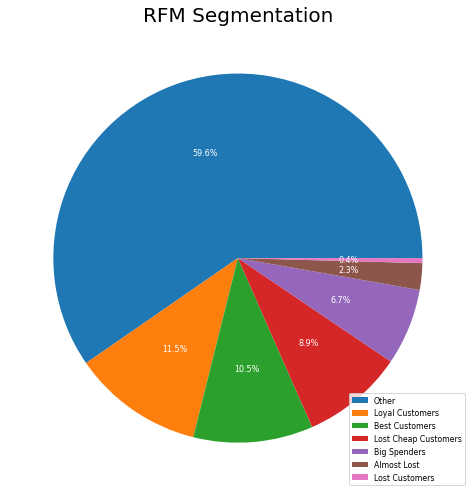

In [34]:
# visualisasi hasil
plt.figure(figsize=(7,7))
plt.pie(cnt_seg["CustomerID"], 
        autopct = '%.1f%%', 
        textprops = {'fontsize' : 8, 
                     'color' : 'white'})
plt.title("RFM Segmentation", fontsize=20)
plt.legend(cnt_seg["segment"], loc='lower right', prop={'size': 7.7})
plt.tight_layout()
plt.show()


- Jumkah dari other berada sekitar 59.6%, dan masih dapat dilakukan segmentasi lebih lanjut untuk mendapat insight yang jelas.
- Segmentasi paling besar setelah others adalah loyal customer dan best customer dimana ini menunjukkan bahwa angka customer sehat masih cukup tinggi dan dengan campaign kedepannya jumlah customer ini masih dapat ditingkatkan.
- Angka customer best customer berada di angka 10.5% dan dapat di tingkatkan dengan loyalty program untuk melindungi customer ini.
- Jika kita mempertimbangkan customer 'Lost Cheap Customers', 'Lost Customers', and 'Almost Lost' sebagai customer churn, maka angka customer churn berada sekitar 11.6% dari total customer, dimana hal ini perlu membutuhkan perhatian lebih lanjut.

## CLUSTERING

In [35]:
# ubah menjadi bentuk array
X = rfm[["recency", "monetary"]]

In [36]:
# range k dari Kmeans
k = range(1, 10)
inertia = [] 
for i in k:
    model = KMeans(n_clusters = i, max_iter = 1000, random_state=0) # jumlah cluster akan di loop sebanyak k range(9 times)
    model.fit(X)
    inertia.append(model.inertia_)


In [37]:
for i,j in enumerate(inertia):
    print(f'Iterasi {i} - inertia = {j}')

Iterasi 0 - inertia = 295338808219.3727
Iterasi 1 - inertia = 100057878094.20795
Iterasi 2 - inertia = 49222777286.93028
Iterasi 3 - inertia = 30246399058.472122
Iterasi 4 - inertia = 17858016241.768677
Iterasi 5 - inertia = 11668509630.058674
Iterasi 6 - inertia = 8467881253.409416
Iterasi 7 - inertia = 5504603249.735132
Iterasi 8 - inertia = 4082218715.3147945


> K = 4

In [38]:
model_km = KMeans(n_clusters=4, max_iter= 1000, random_state=0)

In [39]:
model_km.fit(X)

KMeans(max_iter=1000, n_clusters=4, random_state=0)

In [40]:
rfm['cluster_km'] = model_km.predict(X)

In [41]:
rfm.head()

,CustomerID,last_trans_date,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,segment,cluster_km
0,12346.0,2011-01-18,325,2,0.00,4,4,4,444,Lost Cheap Customers,0
1,12347.0,2011-12-07,2,182,4310.00,1,1,1,111,Best Customers,0
2,12348.0,2011-09-25,75,31,1797.24,3,3,1,331,Big Spenders,0
3,12349.0,2011-11-21,18,73,1757.55,2,2,1,221,Big Spenders,0
4,12350.0,2011-02-02,310,17,334.40,4,4,3,443,Other,0


In [42]:
rfm['cluster_km'].value_counts()

0    4252
3     102
2      15
1       3
Name: cluster_km, dtype: int64

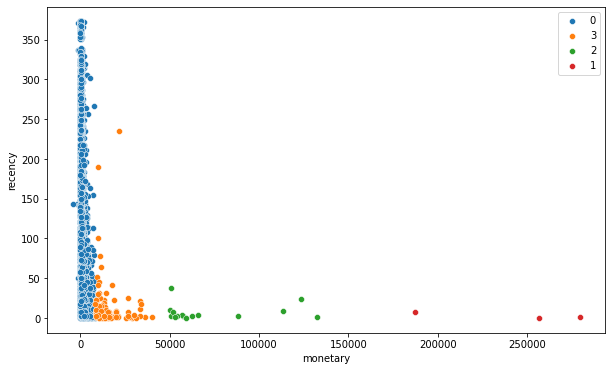

In [43]:
plt.figure(figsize=(10,6))
for i in rfm['cluster_km'].unique():
    sns.scatterplot(rfm['monetary'][rfm['cluster_km']==i], rfm['recency'][rfm['cluster_km']==i], label=i)
plt.legend()
plt.show()

> **Description** :
- **Cluster 0** is a type of customer who has low monetary and various recencies.
> - **Cluster 3** is a type of customer with moderate monetary and recency between 0-250.
> - **Cluster 2** is a type of customer whose monetary value is quite high, around 50000 - 140000 and recency is below 50.
> - **Cluster 3** is a type of customer with high monetary and recency below 50.



## EXPLORATORY DATA ANALYSIS



In [44]:
res = pd.merge(df1, rfm, on = 'CustomerID')

In [45]:
res.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalCost,TransactionDate,...,last_trans_date,recency,frequency,monetary,R_Quartile,F_Quartile,M_Quartile,RFMScore,segment,cluster_km
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,...,2011-02-10,302,312,5288.63,4,1,1,411,Lost Customers,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,2011-02-10,302,312,5288.63,4,1,1,411,Lost Customers,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,...,2011-02-10,302,312,5288.63,4,1,1,411,Lost Customers,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,2011-02-10,302,312,5288.63,4,1,1,411,Lost Customers,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,...,2011-02-10,302,312,5288.63,4,1,1,411,Lost Customers,0


### How was the sales trend over the months?

In [46]:
res['month'] = pd.DatetimeIndex(res['TransactionDate']).month

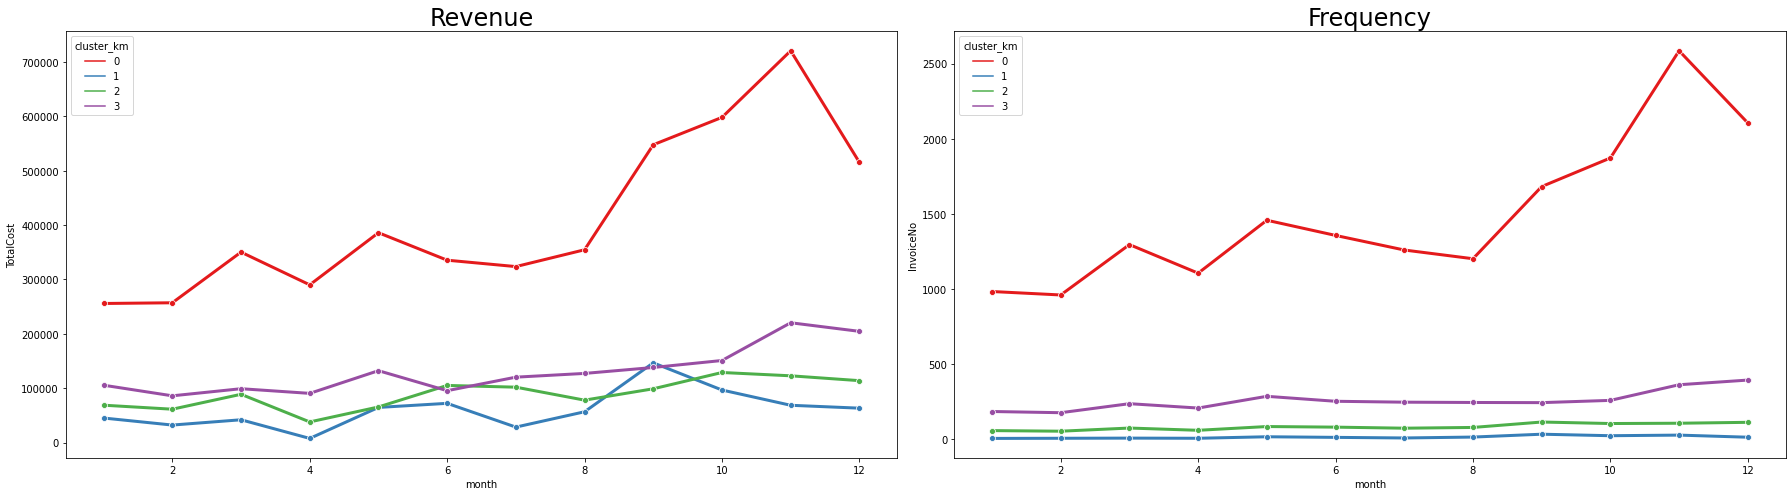

In [47]:
fig, ax = plt.subplots(1,2, figsize=(25,7))
sns.lineplot(data=res.groupby(by=['month', 'cluster_km'])['TotalCost'].sum().reset_index(), x='month', y='TotalCost', hue='cluster_km', palette='Set1', marker="o", linewidth = 3, ax=ax[0])
sns.lineplot(data=res.groupby(by=['month', 'cluster_km'])['InvoiceNo'].nunique().reset_index(), x='month', y='InvoiceNo', hue='cluster_km', palette='Set1', marker="o", linewidth = 3, ax=ax[1])
ax[0].set_title('Revenue', fontsize=24)
ax[1].set_title('Frequency', fontsize=24)
plt.tight_layout()
plt.show()

- Berdasarkan plot diatas dapat terlihat bahwa penjualan tertinggi berada di bulan november sedangkan terendah berada di bulan februari.
- Berdasarkan plot diatas dapat terlihat bahwa tren tiap bulannya tidak menentu namun peningkatan penjualan paling signifikan terjadi dari bulan agustus-september-oktober-november.

### What are the most frequent purchased products?

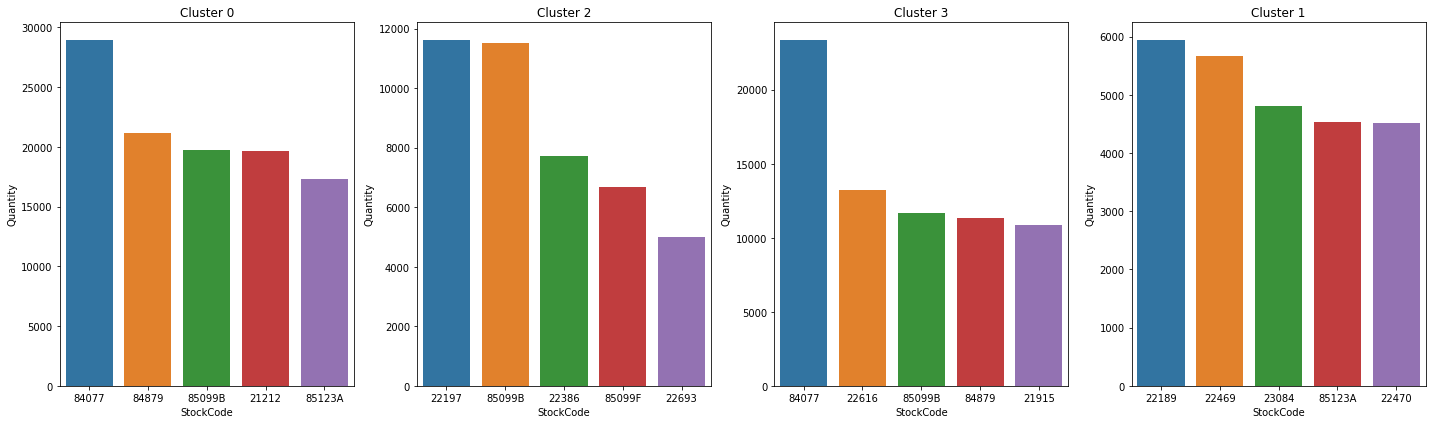

In [48]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20,6))
col = 0
for i in res['cluster_km'].unique():
  axs[col].set_title(f'Cluster {i}')
  z = res[res['cluster_km'] == i].groupby(by=['StockCode', 'Description'])['Quantity'].sum().sort_values(ascending=False).reset_index().head(5)
  sns.barplot(data=z, x='StockCode', y='Quantity', ax=axs[col])
  col+=1
plt.tight_layout()
plt.show()

In [49]:
for i in res['cluster_km'].unique():
  print(f'cluster {i}')
  print(res[res['cluster_km'] == i].groupby(by=['StockCode', 'Description'])['Quantity'].sum().sort_values(ascending=False).reset_index().head(5))
  print('\n')

cluster 0
  StockCode                         Description  Quantity
0     84077   WORLD WAR 2 GLIDERS ASSTD DESIGNS     28968
1     84879       ASSORTED COLOUR BIRD ORNAMENT     21131
2    85099B             JUMBO BAG RED RETROSPOT     19760
3     21212     PACK OF 72 RETROSPOT CAKE CASES     19636
4    85123A  WHITE HANGING HEART T-LIGHT HOLDER     17326


cluster 2
  StockCode                         Description  Quantity
0     22197                      POPCORN HOLDER     11624
1    85099B             JUMBO BAG RED RETROSPOT     11502
2     22386             JUMBO BAG PINK POLKADOT      7722
3    85099F                JUMBO BAG STRAWBERRY      6675
4     22693  GROW A FLYTRAP OR SUNFLOWER IN TIN      4992


cluster 3
  StockCode                        Description  Quantity
0     84077  WORLD WAR 2 GLIDERS ASSTD DESIGNS     23376
1     22616         PACK OF 12 LONDON TISSUES      13246
2    85099B            JUMBO BAG RED RETROSPOT     11704
3     84879      ASSORTED COLOUR BIRD ORNA

<b>clutter 0</b>
- Produk paling banyak dibeli adalah WORLD WAR 2 GLIDERS ASSTD DESIGNS sebanyak 28968.

<b>cluster 1</b>
- Produk paling banyak dibeli adalah CREAM HEART CARD HOLDER sebanyak 5946.

<b>cluster 2</b>
- Produk paling banyak dibeli adalah POPCORN HOLDERS sebanyak 11624.

<b>cluster 3</b>
- Produk paling banyak dibeli adalah WORLD WAR 2 GLIDERS ASSTD DESIGNS sebanyak 23376.



### How many products does the customer purchase in each transaction?

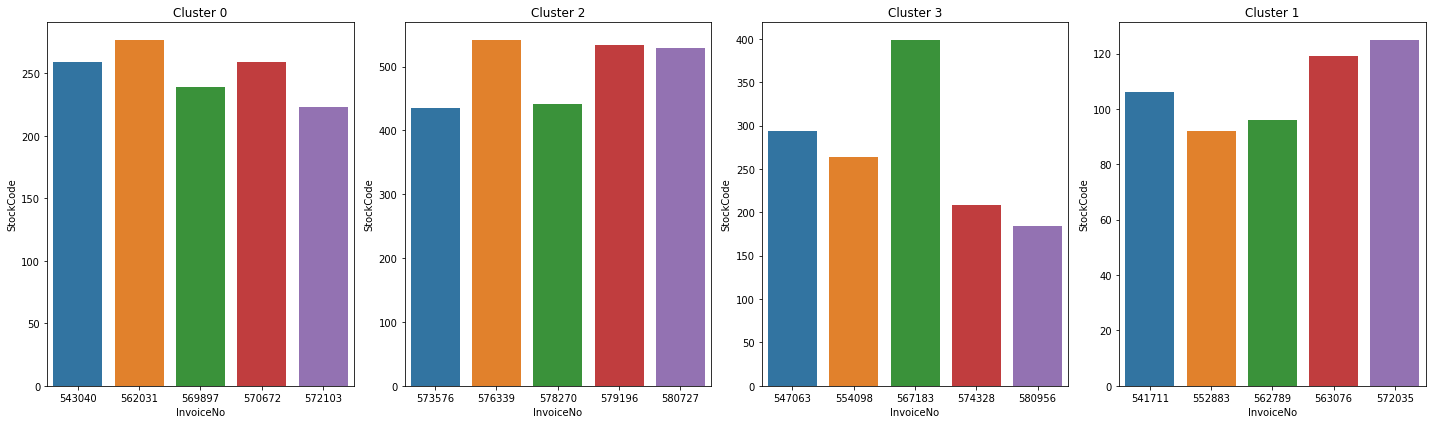

In [50]:
fig, axs = plt.subplots(nrows = 1, ncols = 4, figsize = (20,6))
col = 0
for i in res['cluster_km'].unique():
  axs[col].set_title(f'Cluster {i}')
  z = res[res['cluster_km']==i].groupby(by=['InvoiceNo', 'CustomerID'])['StockCode'].count().sort_values(ascending=False).reset_index().head()
  sns.barplot(data=z, x='InvoiceNo', y='StockCode', ax=axs[col])
  col+=1
plt.tight_layout()
plt.show()

In [51]:
for i in res['cluster_km'].unique():
  print(f'cluster {i}')
  print(res[res['cluster_km']==i].groupby(by=['InvoiceNo', 'CustomerID'])['StockCode'].count().sort_values(ascending=False).head())
  print('\n')

cluster 0
InvoiceNo  CustomerID
562031     16984.0       277
543040     17337.0       259
570672     12536.0       259
569897     17813.0       239
572103     17571.0       223
Name: StockCode, dtype: int64


cluster 2
InvoiceNo  CustomerID
576339     14096.0       542
579196     14096.0       533
580727     14096.0       529
578270     14096.0       442
573576     14096.0       435
Name: StockCode, dtype: int64


cluster 3
InvoiceNo  CustomerID
567183     14769.0       399
547063     14769.0       294
554098     14769.0       264
574328     13081.0       208
580956     17841.0       184
Name: StockCode, dtype: int64


cluster 1
InvoiceNo  CustomerID
572035     14646.0       125
563076     14646.0       119
541711     14646.0       106
562789     14646.0        96
552883     14646.0        92
Name: StockCode, dtype: int64




**cluster 0**
- Jumlah pembelian produk dalam satu transaksi paling banyak sebesar 277 dimana dibeli oleh CustomerId 16984.

**cluster 2**
- Jumlah pembelian produk dalam satu transaksi paling banyak sebesar 542 dimana dibeli oleh CustomerId 14096.

**clusters 3**
- Jumlah pembelian produk dalam satu transaksi paling banyak sebesar 399 dimana dibeli oleh CustomerId 14769.

**cluster 1**
- Jumlah pembelian produk dalam satu transaksi paling banyak sebesar 125 dimana dibeli oleh CustomerId 14646.

### How does each cluster/group contribute to the company's revenue?

In [52]:
z = res.groupby(by='cluster_km')['TotalCost'].sum().reset_index()

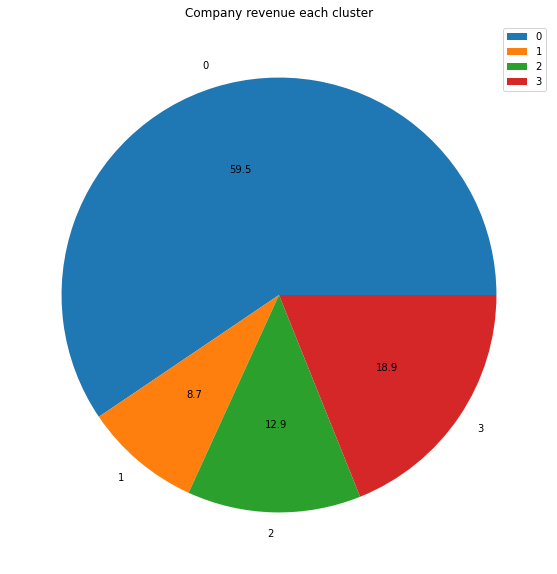

In [53]:
plt.figure(figsize=(10,10))
plt.pie(data=z, x='TotalCost', labels='cluster_km', autopct='%.1f')
plt.title('Company revenue each cluster')
plt.legend()
plt.show()

In [54]:
z['revenue_rate'] = round((100 * z['TotalCost'] / z['TotalCost'].sum()), 1)

In [55]:
z.sort_values(by='revenue_rate', ascending=False)

,cluster_km,TotalCost,revenue_rate
0,0,4935493.204,59.5
3,3,1569810.190,18.9
2,2,1071352.740,12.9
1,1,723409.680,8.7


Berdasarkan plot dan data diatas terlihat bahwa cluster 0 merupakan cluster yang memberi revenue terbesar kepada perusahaan yaitu sebesar 59%, disusul oleh cluster 3 sebesar 18.9%, lalu disusul cluster 2 sebesar 12.9%, dan terakhir ditempati oleh cluster 1 sebesar 8.7%.

### What are the interval date between transactions?

In [56]:
res.groupby(by='cluster_km')['recency'].max()-res.groupby(by='cluster_km')['recency'].min()

cluster_km
0    373
1      8
2     38
3    235
Name: recency, dtype: int64

CLuster 0 memiliki interval terbesar disusul cluster 3, cluster 2 dan cluster 1.

**Based on your findings, what strategy could you recommend to the business to gain more profit?**

- Membuat program-program yang dapat meningkatkan kecepatan restock barang sehingga product yang dicancel semakin kecil yang dimana akan berdampak kepada kepuasaan pelanggan kedepannya.

- **Cluster 0**, customer di cluster ini merupakan customer dengan beragam recency tetapi memiliki monetary yang kecil jadi untuk cluster ini dapat berfokus untuk meingkatkan monetisasi product rekomendasi berdasarkan pembelian sebelumnya seperti memberikan diskon untuk produk yang sering dibeli sepertu GLIDER ASSTD WORLD WAR 2 DESIGN, BIRD DECORATIONS OF VARIOUS COLORS, dll.

- **Cluster 1**, customer di kluster ini merupakan customer yang menunjukkan keinginan untuk membayar yang cukup tinggi. Jadi ada baiknya untuk cluster ini diberikan premium offers, subscription tiers atau cross selling/value untuk meningkatkan AOV.

- **Cluster 2**, customer di cluster ini merupakan customer yang spend uang cukup besar namun memiliki recency yang kecil, jadi untuk kasus ini ada baikknya ckuster ini diberikan program yang dapat meningkatkan recency seperti free shipping, dll.

- **Cluster 3**, Pelanggan cluster ini adalah jenis pelanggan dengan moneter sedang dan recency yang kecil, jadi menurut saya, pelanggan cluster ini dapat diberikan program yang dapat meningkatkan monetary.






## PREDICTIVE MODEL BUILDING


In [57]:
X = res[['Quantity', 'UnitPrice', 'cluster_km']]
y = res['cancelled']

In [58]:
# tarin test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #size test 20%

In [59]:
model_tr = DecisionTreeClassifier()
model_tr.fit(X_train, y_train)

DecisionTreeClassifier()

In [60]:
y_pred_tr = model_tr.predict(X_test)

In [61]:
result_tr = pd.DataFrame()
result_tr['y_act'] = y_test
result_tr['y_pred'] = y_pred_tr

In [62]:
result_tr = pd.concat([X_test,result_tr], axis=1)

In [63]:
result_tr.head()

,Quantity,UnitPrice,cluster_km,y_act,y_pred
149468,40,1.79,0,0,0
288958,12,1.49,0,0,0
129114,2,16.95,0,0,0
63987,10,2.08,2,0,0
191581,12,0.42,0,0,0


Text(33.0, 0.5, 'Actual')

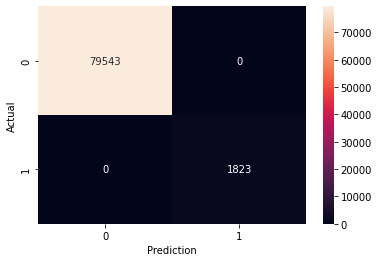

In [64]:
sns.heatmap(confusion_matrix(y_test, y_pred_tr), annot=True, fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [65]:
print(classification_report(y_test, y_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79543
           1       1.00      1.00      1.00      1823

    accuracy                           1.00     81366
   macro avg       1.00      1.00      1.00     81366
weighted avg       1.00      1.00      1.00     81366



In [66]:
def cv_score(model, data_x, data_y, scoring, n):
    
    cv = KFold(n_splits=n, shuffle=False)
    scores_train = cross_val_score(model, data_x, data_y, scoring=scoring, cv=cv)
    scores_test = cross_validate(model, data_x, data_y, cv=n)
    
    plt.figure(figsize=(7,5))
    sns.lineplot(data=scores_train, label='Train', marker='o')
    sns.lineplot(data=scores_test['test_score'], label='Test', marker='o')
    plt.show()

    return pd.DataFrame(data = [scores_train.mean()*100, scores_test['test_score'].mean()*100],
                        index = ['Train', 'Test'],
                        columns =['Score (%)']
                       )
    

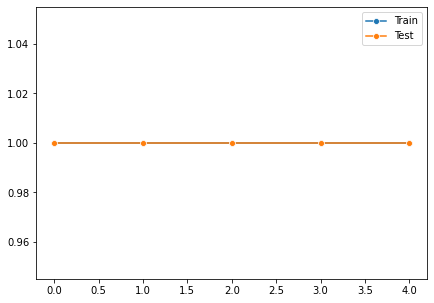

,Score (%)
Train,100.0
Test,100.0


In [67]:
cv_score(model_tr, X_train, y_train, 'recall', 5)

In [68]:
from sklearn.linear_model import LogisticRegression

In [69]:
model_lr = LogisticRegression()

In [70]:
model_lr.fit(X_train, y_train)

LogisticRegression()

In [71]:
y_pred_lr = model_lr.predict(X_test)

In [72]:
result_lr = pd.DataFrame()
result_lr['y_act'] = y_test
result_lr['y_pred'] = y_pred_lr

In [73]:
result_lr = pd.concat([X_test,result_lr], axis=1)

In [74]:
result_lr.head()

,Quantity,UnitPrice,cluster_km,y_act,y_pred
149468,40,1.79,0,0,0
288958,12,1.49,0,0,0
129114,2,16.95,0,0,0
63987,10,2.08,2,0,0
191581,12,0.42,0,0,0


Text(33.0, 0.5, 'Actual')

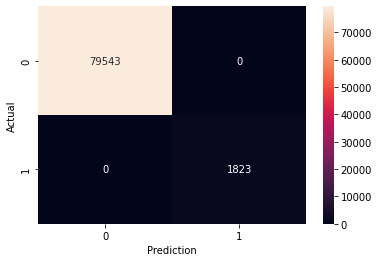

In [75]:
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='.0f')
plt.xlabel('Prediction')
plt.ylabel('Actual')

In [76]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79543
           1       1.00      1.00      1.00      1823

    accuracy                           1.00     81366
   macro avg       1.00      1.00      1.00     81366
weighted avg       1.00      1.00      1.00     81366



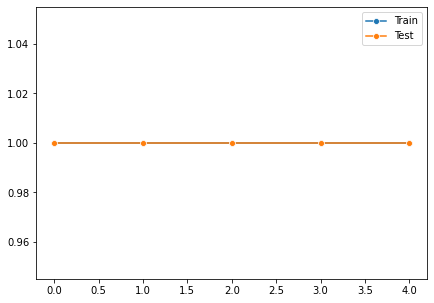

,Score (%)
Train,100.0
Test,100.0


In [77]:
cv_score(model_lr, X_train, y_train, 'recall', 5)

### MODEL EVALUATION

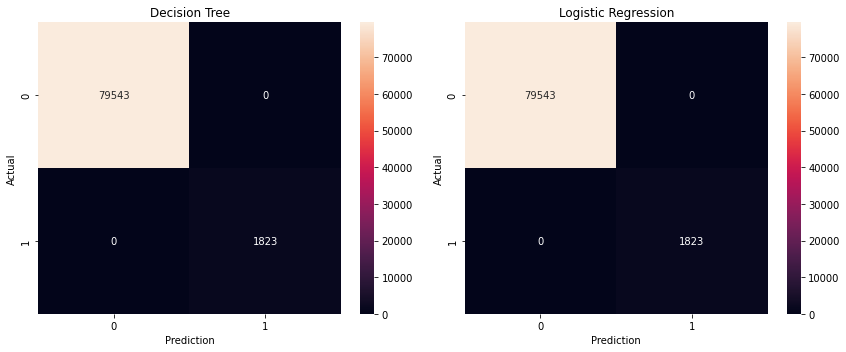

In [78]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
sns.heatmap(confusion_matrix(y_test, y_pred_tr), annot=True, fmt='.0f', ax=ax[0])
ax[0].set_xlabel('Prediction')
ax[0].set_ylabel('Actual')
ax[0].set_title('Decision Tree')

sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='.0f', ax=ax[1])
ax[1].set_xlabel('Prediction')
ax[1].set_ylabel('Actual')
ax[1].set_title('Logistic Regression')
plt.tight_layout()
plt.show()

In [79]:
print(classification_report(y_test, y_pred_tr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79543
           1       1.00      1.00      1.00      1823

    accuracy                           1.00     81366
   macro avg       1.00      1.00      1.00     81366
weighted avg       1.00      1.00      1.00     81366



In [80]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     79543
           1       1.00      1.00      1.00      1823

    accuracy                           1.00     81366
   macro avg       1.00      1.00      1.00     81366
weighted avg       1.00      1.00      1.00     81366



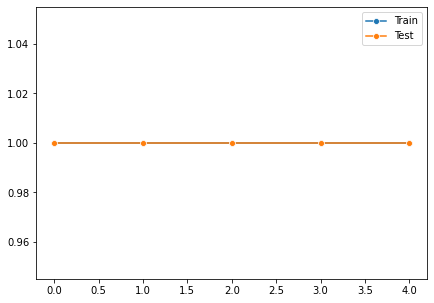

,Score (%)
Train,100.0
Test,100.0


In [93]:
cv_score(model_tr, X_train, y_train, 'recall', 5)

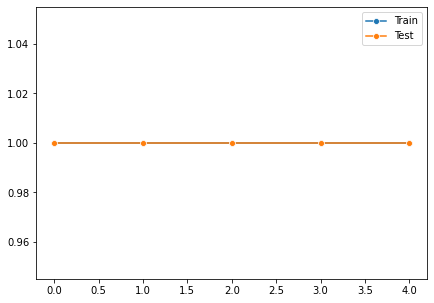

,Score (%)
Train,100.0
Test,100.0


In [94]:
cv_score(model_lr, X_train, y_train, 'recall', 5)

> Berdasarkan k-fold dan juga classification_report dapat dikatakan model overfit, Dimana k-fold skor untuk train dan test 100% dan juga model tepat mempredik semua kemungkinan tanpa kesalahan berdasarkan data.

## CONCLUSION
1. Penjualan tertinggi berada di bulan november sedangkan terendah berada di bulan februari. Trend tiap bulannya tidak menentu namun peningkatan penjualan paling signifikan terjadi dari bulan agustus-september-oktober-november.

2. Cluster 0 merupakan cluster yang memberi revenue terbesar kepada perusahaan yaitu sebesar 59%, disusul oleh cluster 3 sebesar 18.9%, lalu disusul cluster 2 sebesar 12.9%, dan terakhir ditempati oleh cluster 1 sebesar 8.7%.

3. CLuster 0 memiliki interval terbesar disusul cluster 3, cluster 2 dan cluster 1.

4. Membuat program-program yang dapat meningkatkan kecepatan restock barang sehingga product yang dicancel semakin kecil yang dimana akan berdampak kepada kepuasaan pelanggan kedepannya.

5. Cluster 0, customer di cluster ini merupakan customer dengan beragam recency tetapi memiliki monetary yang kecil jadi untuk cluster ini dapat berfokus untuk meingkatkan monetisasi product rekomendasi berdasarkan pembelian sebelumnya seperti memberikan diskon untuk produk yang sering dibeli sepertu GLIDER ASSTD WORLD WAR 2 DESIGN, BIRD DECORATIONS OF VARIOUS COLORS, dll.

6. Cluster 1, customer di kluster ini merupakan customer yang menunjukkan keinginan untuk membayar yang cukup tinggi. Jadi ada baiknya untuk cluster ini diberikan premium offers, subscription tiers atau cross selling/value untuk meningkatkan AOV.

7. Cluster 2, customer di cluster ini merupakan customer yang spend uang cukup besar namun memiliki recency yang kecil, jadi untuk kasus ini ada baikknya ckuster ini diberikan program yang dapat meningkatkan recency seperti free shipping, dll.

8. Cluster 3, Pelanggan cluster ini adalah jenis pelanggan dengan moneter sedang dan recency yang kecil, jadi menurut saya, pelanggan cluster ini dapat diberikan program yang dapat meningkatkan monetary.

9. Model decision tree dan logistic regression overfit dan menurut saya solusi atas permasalahan ini adalah dengan menambah data pada model ini agar model dapat belajar dari data yang beragam.